In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import nrrd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import nnunet

# from nnunet.dataset_conversion.utils import dataset_conversion
from ipywidgets import interact, fixed
from IPython.display import display
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Tuple, List, Union
from skimage import io
from pathlib import Path
from typing import Tuple
from batchgenerators.utilities.file_and_folder_operations import *



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [34]:
# directories
# change these to match where your existing data is and should be
# name of dataset directory
dataset_name = "label1and2/"
# name of task for nnU-Net to recognise
task_name = "Task104_Ovary/"
base_dir = '/vol/bitbucket/ma3720/thesis/datasets/' + dataset_name
raw_data_dir = '/vol/bitbucket/ma3720/thesis/nnUNet_raw/nnUNet_raw_data/'
tr_img_dir = raw_data_dir + task_name + 'imagesTr/'
tr_label_dir = raw_data_dir + task_name + 'labelsTr/'
ts_img_dir = raw_data_dir + task_name + 'imagesTs/'
ts_label_dir = raw_data_dir + task_name + 'labelsTs/'
json_dir = raw_data_dir + task_name + 'dataset.json'
predicted_dir = '/vol/bitbucket/ma3720/thesis/results/' + task_name
overlayed_dir = '/vol/bitbucket/ma3720/thesis/overlayed/' + task_name

In [33]:
# calculate dice and jaacard index for single label
# labels_dir = ts_label_dir

labels_dir = '/vol/bitbucket/ma3720/thesis/nnUNet_raw/nnUNet_raw_data/Task103_Ovary/labelsTr/'
predicted_dir = "/vol/bitbucket/ma3720/thesis/nnUNet_trained_models/nnUNet/2d/Task103_Ovary/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed/"
results_files = os.listdir(predicted_dir)

dices = []
jaccards = []
precisions = []
recalls = []
accuracies = []

# select label_number to calculate metrics for
label_number = 1

for file in results_files:
    if file.endswith('gz'):
        # get arrays of images
        prd_img = predicted_dir + file
        lbl_img = labels_dir + file
        prd_img = sitk.ReadImage(prd_img)
        prd_img = sitk.GetArrayFromImage(prd_img)
        lbl_img = sitk.ReadImage(lbl_img)
        lbl_img = sitk.GetArrayFromImage(lbl_img)
        lbl_img = np.squeeze(lbl_img)
        prd_img = np.squeeze(prd_img)

        # Image at this point still has label 1 as only what isn't label 2, since that's how nnU-Net is trained (overlapping is not allowed). To get the actual label 1, we get the union of label 1 and label 2.
        fixed_lbl = lbl_img
        fixed_lbl[fixed_lbl>label_number] = label_number
        fixed_prd = prd_img
        fixed_prd[fixed_prd>label_number] = label_number

        # confusion matrix
        tp = (fixed_prd[fixed_lbl == label_number] == label_number).sum()
        fp = (fixed_prd[fixed_lbl != label_number] == label_number).sum()
        fn = (fixed_prd[fixed_lbl == label_number] != label_number).sum()
        tn = (fixed_prd[fixed_lbl != label_number] != label_number).sum()

        # metrics
        dice = tp*2/(tp*2 + fp + fn)
        jaccard = tp/(tp+fp+fn)
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        accuracy = (tp + tn)/(tp + tn + fp + fn)

        dices.append(dice)
        jaccards.append(jaccard)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
print('Dice similarity score is {}'.format(np.average(dices)))
print('Jaccard index is {}'.format(np.average(jaccards)))
print('Precision is {}'.format(np.average(precisions)))
print('Recall is {}'.format(np.average(recalls)))
print('Accuracy is {}'.format(np.average(accuracies)))
        

Dice similarity score is 0.9074959637292372
Jaccard index is 0.843493790815202
Precision is 0.9268430450487474
Recall is 0.9069475823594422
Accuracy is 0.9740728759765624


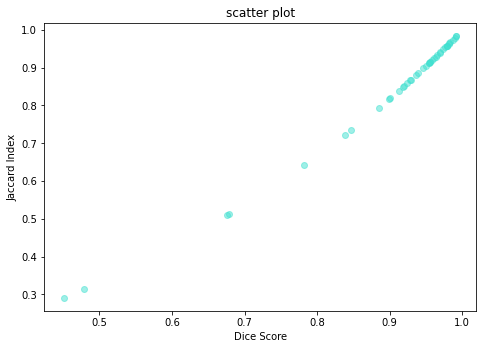

In [11]:
# make scatter plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(dices, jaccards, color='turquoise', alpha=0.5)
ax.set_xlabel('Dice Score')
ax.set_ylabel('Jaccard Index')
ax.set_title('scatter plot')
plt.show()

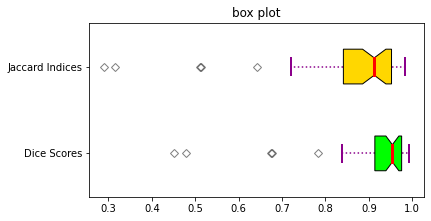

In [23]:
# code borrowed from https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# generate box plot
data = [dices, jaccards]
fig = plt.figure()
ax = fig.add_subplot()
bp = ax.boxplot(data, patch_artist = True, 
                notch ='True', vert = 0, widths=0.4)

colors = ['lime', 'gold']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(['Dice Scores', 'Jaccard Indices'])
 
# Adding title
plt.title("box plot")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_aspect(0.2)
     
# show plot
plt.show(bp)

In [50]:
# calculate dice and jaacard index for single label for all iterations
# labels_dir = ts_label_dir

labels_dirs = ['/vol/bitbucket/ma3720/thesis/nnUNet_raw/nnUNet_raw_data/Task102_Ovary/labelsTs/', '/vol/bitbucket/ma3720/thesis/nnUNet_raw/nnUNet_raw_data/Task103_Ovary/labelsTs/',
'/vol/bitbucket/ma3720/thesis/nnUNet_raw/nnUNet_raw_data/Task104_Ovary/labelsTs/']
predicted_dirs = ['/vol/bitbucket/ma3720/thesis/results/Task102_Ovary/', '/vol/bitbucket/ma3720/thesis/results/Task103_Ovary/', '/vol/bitbucket/ma3720/thesis/results/Task104_Ovary/']

all_dices = []
all_jaccards = []
for i in range(len(labels_dirs)):

    labels_dir = labels_dirs[i]
    predicted_dir = predicted_dirs[i]
    results_files = os.listdir(predicted_dir)

    dices = []
    jaccards = []

    # select label_number to calculate metrics for
    label_number = 2

    for file in results_files:
        if file.endswith('gz'):
            # get arrays of images
            prd_img = predicted_dir + file
            lbl_img = labels_dir + file
            prd_img = sitk.ReadImage(prd_img)
            prd_img = sitk.GetArrayFromImage(prd_img)
            lbl_img = sitk.ReadImage(lbl_img)
            lbl_img = sitk.GetArrayFromImage(lbl_img)
            lbl_img = np.squeeze(lbl_img)
            prd_img = np.squeeze(prd_img)

            # Image at this point still has label 1 as only what isn't label 2, since that's how nnU-Net is trained (overlapping is not allowed). To get the actual label 1, we get the union of label 1 and label 2.
            fixed_lbl = lbl_img
            fixed_lbl[fixed_lbl>label_number] = label_number
            fixed_prd = prd_img
            fixed_prd[fixed_prd>label_number] = label_number

            # confusion matrix
            tp = (fixed_prd[fixed_lbl == label_number] == label_number).sum()
            fp = (fixed_prd[fixed_lbl != label_number] == label_number).sum()
            fn = (fixed_prd[fixed_lbl == label_number] != label_number).sum()
            tn = (fixed_prd[fixed_lbl != label_number] != label_number).sum()

            # metrics
            dice = tp*2/(tp*2 + fp + fn)
            jaccard = tp/(tp+fp+fn)

            dices.append(dice)
            jaccards.append(jaccard)
    all_dices.append(dices)
    all_jaccards.append(jaccards)
print(np.mean(all_jaccards[2]))
        

0.8219855691299037


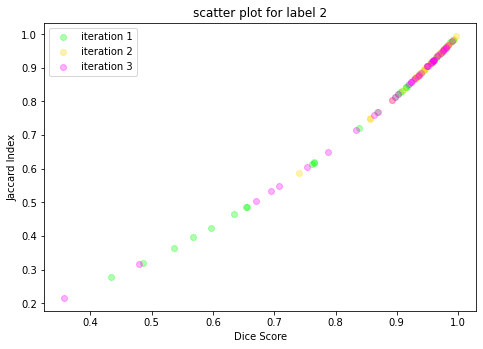

In [51]:
# make scatter plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
colors = ['lime', 'gold', 'fuchsia']
for i in range(len(all_dices)):
    ax.scatter(all_dices[i], all_jaccards[i], color=colors[i], alpha=0.3)
ax.legend(['iteration 1', 'iteration 2', 'iteration 3'])
ax.set_xlabel('Dice Score')
ax.set_ylabel('Jaccard Index')
ax.set_title('scatter plot for label 2')
plt.show()

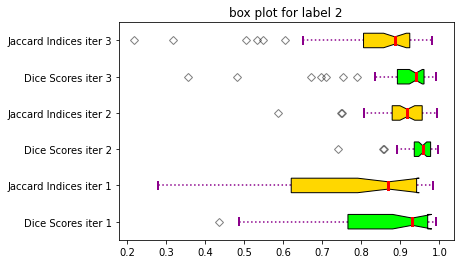

In [54]:
# code borrowed from https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
# generate box plot
data = [all_dices[0], all_jaccards[0], all_dices[1], all_jaccards[1], all_dices[2], all_jaccards[2]]
fig = plt.figure()
ax = fig.add_subplot()
bp = ax.boxplot(data, patch_artist = True, 
                notch ='True', vert = 0, widths=0.4)

colors = ['lime', 'gold', 'lime', 'gold', 'lime', 'gold']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(['Dice Scores iter 1', 'Jaccard Indices iter 1', 'Dice Scores iter 2', 'Jaccard Indices iter 2', 'Dice Scores iter 3', 'Jaccard Indices iter 3'])
 
# Adding title
plt.title("box plot for label 2")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
# ax.set_aspect(0.2)
     
# show plot
plt.show(bp)